# Développez un moteur de recommandations de films

## Récupération et visualisation des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 200)
plt.style.use('default')

In [2]:
# Méthode de suppression de colonne
def DropCol(p_df, p_col):
    if p_col in p_df.columns:
        p_df = p_df.drop([p_col], axis=1)
    return p_df

In [3]:
# Récupération du fichier en local
df = pd.read_csv('movie_metadata_cleaned.csv', sep="\t", encoding='utf-8')
df.tail()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
4914,Color,Scott Smith,1.0,87.0,2.0,318.0,Daphne Zuniga,637.0,25035665.0,Comedy|Drama,Eric Mabius,Signed Sealed Delivered,629,2283.0,Crystal Lowe,2.0,fraud|postal worker|prison|theft|trial,6.0,English,Canada,R,19900000.0,2013.0,470.0,7.7,2.00,84
4915,Color,NaN,43.0,43.0,48.0,319.0,Valorie Curry,841.0,25035665.0,Crime|Drama|Mystery|Thriller,Natalie Zea,The Following,73839,1753.0,Sam Underwood,1.0,cult|fbi|hideout|prison escape|serial killer,359.0,English,USA,TV-14,19900000.0,2009.0,593.0,7.5,16.00,32000
4916,Color,Benjamin Roberds,13.0,76.0,0.0,0.0,Maxwell Moody,0.0,25035665.0,Drama|Horror|Thriller,Eva Boehnke,A Plague So Pleasant,38,0.0,David Chandler,0.0,NaN,3.0,English,USA,R,1400.0,2013.0,0.0,6.3,2.00,16
4917,Color,Daniel Hsia,14.0,100.0,0.0,489.0,Daniel Henney,946.0,10443.0,Comedy|Drama|Romance,Alan Ruck,Shanghai Calling,1255,2386.0,Eliza Coupe,5.0,NaN,9.0,English,USA,PG-13,19900000.0,2012.0,719.0,6.3,2.35,660
4918,Color,Jon Gunn,43.0,90.0,16.0,16.0,Brian Herzlinger,86.0,85222.0,Documentary,John August,My Date with Drew,4285,163.0,Jon Gunn,0.0,actress name in title|crush|date|four word tit...,84.0,English,USA,PG,1100.0,2004.0,23.0,6.6,1.85,456


## Matrice de corrélation

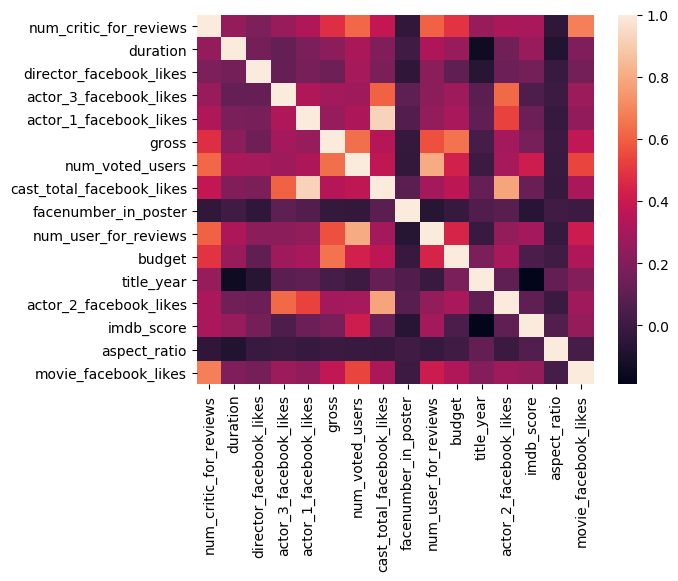

In [4]:
#Correlation Heat Map
import seaborn as sns
sns.heatmap(df.corr())

## Transformation

In [5]:
# Méthode de création d'une colonne avec tous les mots clés
KEYWORDSCOL = 'all_keywords'
def CreateCol(p_df, p_cols):
    dfnotnull = p_df.fillna('')
    tmp = ""
    for col in p_cols:
        if len(tmp) > 0:
            tmp += '|'
        tmp += dfnotnull[col]
    #p_df = p_df.assign(all_keywords=tmp)
    ret = pd.DataFrame({KEYWORDSCOL : tmp})
    return ret

In [6]:
# Création d'une colonne avec tous les mots clés de la colonne 'genres'
#cols = ['genres'] #ça et cosine, meilleur avec shrek

# On peut aussi y mettre un ensemmble de mots clés mais pas trop (bien avec les )
#cols = ['genres', 'director_name', 'actor_1_name', 'language', 'movie_title']

# On peut aussi y mettre un ensemmble de mots clés
cols = ['genres', 'plot_keywords', 'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'color', 'language', 'country', 'content_rating', 'movie_title']

df_keywords = CreateCol(df[cols], cols)
df_keywords.head()

,all_keywords
0,Action|Adventure|Fantasy|Sci-Fi|avatar|future|...
1,Action|Adventure|Fantasy|goddess|marriage cere...
2,Action|Adventure|Thriller|bomb|espionage|seque...
3,Action|Thriller|deception|imprisonment|lawless...
4,Documentary||Doug Walker|Doug Walker|Rob Walke...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def token(text):
    return(text.split('|'))
cv = CountVectorizer(tokenizer=token)

colTransformed = cv.fit_transform(df_keywords[KEYWORDSCOL])

lst = cv.get_feature_names()
print(len(lst))

In [29]:
sorted(lst)

['',
 ' black and white',
 '#horror',
 '10 cloverfield lane',
 '10 days in a madhouse',
 '10 things i hate about you',
 '10 year old',
 '10,000 b.c.',
 '1000000 b.c.',
 '102 dalmatians',
 '10th & wolf',
 '1190s',
 '11:14',
 '12 angry men',
 '12 monkeys',
 '12 rounds',
 '12 step program',
 '12 year old',
 '12 year time span',
 '12 years a slave',
 '127 hours',
 '12th century',
 '13 going on 30',
 '13 hours',
 '13 year old',
 '13 year olds',
 '13th birthday',
 '14 year old',
 '1408',
 '14th century',
 '15 minutes',
 '15 year old',
 '1520s',
 '15th birthday',
 '15th century',
 '16 blocks',
 '16 to life',
 '16 year old',
 '16th century',
 '17 again',
 '1770s',
 '1776',
 '17th century',
 '18 wheeler',
 '1800s',
 '1810s',
 '1830s',
 '1850s',
 '1860s',
 '1880s',
 '1890s',
 '18th birthday',
 '18th century',
 '1910s',
 '1911',
 '1920s',
 '1930s',
 '1940s',
 '1941',
 '1950s',
 '1955 chevrolet',
 '1959 cadillac',
 '1960s',
 '1969 dodge charger',
 '1970s',
 '1980s',
 '1982',
 '1988 winter olympics

In [8]:
# On crée une matrice pour remplacer le genre
tmp = pd.DataFrame(cv.transform(df_keywords[KEYWORDSCOL]).toarray(), index=df.index)
tmp = tmp.rename(columns = lambda x: "key_"+lst[x])
print (tmp.shape)
tmp

(4919, 21286)


,key_,key_ black and white,key_#horror,key_10 cloverfield lane,key_10 days in a madhouse,key_10 things i hate about you,key_10 year old,"key_10,000 b.c.",key_1000000 b.c.,key_102 dalmatians,key_10th & wolf,key_1190s,key_11:14,key_12 angry men,key_12 monkeys,key_12 rounds,key_12 step program,key_12 year old,key_12 year time span,key_12 years a slave,key_127 hours,key_12th century,key_13 going on 30,key_13 hours,key_13 year old,key_13 year olds,key_13th birthday,key_14 year old,key_1408,key_14th century,key_15 minutes,key_15 year old,key_1520s,key_15th birthday,key_15th century,key_16 blocks,key_16 to life,key_16 year old,key_16th century,key_17 again,key_1770s,key_1776,key_17th century,key_18 wheeler,key_1800s,key_1810s,key_1830s,key_1850s,key_1860s,key_1880s,key_1890s,key_18th birthday,key_18th century,key_1910s,key_1911,key_1920s,key_1930s,key_1940s,key_1941,key_1950s,key_1955 chevrolet,key_1959 cadillac,key_1960s,key_1969 dodge charger,key_1970s,key_1980s,key_1982,key_1988 winter olympics,key_1990s,key_19th century,key_1st century,key_1st century b.c.,key_2 fast 2 furious,key_2 guns,key_20 dates,key_20 feet from stardom,key_20 years later,"key_20,000 leagues under the sea",key_200 cigarettes,key_2000s,key_2001: a space odyssey,key_2010s,key_2012,key_2016: obama's america,key_2020s,key_2030s,key_2046,key_20th century,key_21,key_21 & over,key_21 grams,key_21 jump street,key_21 year old,key_21st birthday,key_21st century,key_22 jump street,key_22 year old,key_22nd century,key_23 year time span,key_23rd century,...,key_yuri lowenthal,key_yuria nara,key_yuriy tsurilo,key_yuval diskin,key_yves jacques,key_yvette mimieux,key_yvette nicole brown,key_yvonne zima,key_yû aoi,key_yûki amami,key_yûsuke iseya,key_z storm,key_zach braff,key_zach callison,key_zach cregger,key_zach galligan,key_zach gilford,key_zach grenier,key_zach mcgowan,key_zach mills,key_zach woods,key_zachary gordon,key_zachary knighton,key_zachery ty bryan,key_zack and miri make a porno,key_zack pearlman,key_zack snyder,key_zack ward,key_zackary adler,key_zackary steven graham,key_zahava solomon,key_zahn mcclarnon,key_zaide silvia gutiérrez,key_zak orth,key_zak penn,key_zakes mokae,key_zal batmanglij,key_zambezia,key_zamboni,key_zan marolt,key_zane holtz,key_zathura: a space adventure,key_zayn malik,key_zealot,key_zebra,key_zelda rubinstein,key_zen,key_zen mcgrath,key_zena grey,key_zero dark thirty,key_zero effect,key_zero gravity,key_zero mostel,key_zeus,key_zhanna friske,key_zheng xu,key_zhengyong zhang,key_zhonghua chen,key_zinedine soualem,key_zipper,key_zmd: zombies of mass destruction,key_zodiac,key_zodiac killer,key_zoe kazan,key_zoe levin,key_zoe lister-jones,key_zoe ventoura,key_zoey deutch,key_zohra segal,key_zoloft,key_zombie,key_zombie apocalypse,key_zombie hunter,key_zombie spoof,key_zombieland,key_zoo,key_zooey deschanel,key_zookeeper,key_zoolander,key_zoolander 2,key_zoologist,key_zoom,key_zoran lisinac,key_zorro,key_zoë bell,key_zoë kravitz,key_zoë poledouris,key_zubaida sahar,key_zuhair haddad,key_zulu,key_álex angulo,key_álex de la iglesia,key_ángela molina,key_æon flux,key_émile gaudreault,key_émilie dequenne,key_éric tessier,key_étienne faure,key_ólafur darri ólafsson,key_óscar jaenada
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [31]:
# Comme on a créé beaucoup de colonnes on supprime celles qui n'ont qu'un représentant
i = 0
col_to_remove = []
for col in tmp.columns:
    if tmp[col].sum() == 1:
        col_to_remove.append(col)
        i += 1
        continue
    # Et la colonne sans clé
    if col == 'key_':
        col_to_remove.append(col)
        i += 1
print(i, 'colonnes supprimées')
tmp = tmp.drop(col_to_remove, axis=1)
tmp.shape

0 colonnes supprimées


,key_ black and white,key_12 step program,key_12 year old,key_14 year old,key_14th century,key_15 year old,key_16th century,key_17th century,key_1800s,key_1880s,key_18th birthday,key_18th century,key_1910s,key_1920s,key_1930s,key_1940s,key_1950s,key_1960s,key_1970s,key_1980s,key_1990s,key_19th century,key_2000s,key_2010s,key_21st century,key_23rd century,key_3 dimensional,key_3d,key_3d in title,key_50 cent,key_9 year old,key_a cappella,key_a.j. buckley,key_aaliyah,key_aaron ashmore,key_aaron stanford,key_aaron yoo,key_aasif mandvi,key_abandoned,key_abandoned building,key_abbie cornish,key_abbreviation in title,key_abduction,key_abhishek bachchan,key_abigail spencer,key_aboriginal,key_aborigine,key_abortion,key_abraham benrubi,key_absent father,key_absurd humor,key_abu ghraib,key_abuse,key_abuse of power,key_abusive father,key_abusive husband,key_accident,key_accidental death,key_accountant,key_action,key_action figure,key_action hero,key_action heroine,key_activist,key_actor,key_actor playing multiple roles,key_actress,key_actress shares first name with character,key_actual animal killed,key_adam arkin,key_adam baldwin,key_adam brown,key_adam carolla,key_adam garcia,key_adam goldberg,key_adam lefevre,key_adam mckay,key_adam rifkin,key_adam sandler,key_adam scott,key_adam shankman,key_addiction,key_aden young,key_adhir kalyan,key_adolescence,key_adoption,key_adrian lyne,key_adrian martinez,key_adriana barraza,key_adrienne barbeau,key_adulterous wife,key_adultery,key_adventure,key_advertising,key_advertising executive,key_advice,key_affair,key_afghanistan,key_africa,key_african american,...,key_witch hunter,key_witchcraft,key_witness,key_witness protection,key_witness protection program,key_wizard,key_wizard of oz,key_wolf,key_wolfgang petersen,key_woman on top,key_woman slaps a man,key_woman wearing a string bikini,key_woman wearing only a man's shirt,key_womanizer,key_womb,key_woo-sung jung,key_wood harris,key_woods,key_woodstock,key_woody allen,key_woody strode,key_work,key_workaholic,key_worker,key_working class,key_world cup,key_world war one,key_world war three,key_world war two,key_wormhole,key_wrestler,key_wrestling,key_wristwatch,key_writer,key_writer's block,key_writing,key_written and directed by cast member,key_written by director,key_written by star,key_wrongful arrest,key_wrongful conviction,key_wuxia,key_wyatt earp,key_wyoming,key_x,key_x men,key_xander berkeley,key_xavier gens,key_xzibit,key_yacht,key_yakuza,key_yaphet kotto,key_yard sale,key_yash chopra,key_yaya dacosta,key_ye liu,key_year 1949,key_year 1987,key_year 2002,key_year 2054,key_yeardley smith,key_yellowstone national park,key_yimou zhang,key_yogi bear,key_yorkshire,key_young love,key_young woman,key_younger version of character,key_youssef delara,key_yvette nicole brown,key_zach braff,key_zach galligan,key_zach gilford,key_zach grenier,key_zach woods,key_zachary gordon,key_zack snyder,key_zack ward,key_zak penn,key_zakes mokae,key_zal batmanglij,key_zebra,key_zelda rubinstein,key_zeus,key_zheng xu,key_zinedine soualem,key_zodiac,key_zoe kazan,key_zoey deutch,key_zombie,key_zombie apocalypse,key_zombie spoof,key_zoo,key_zooey deschanel,key_zookeeper,key_zorro,key_zoë bell,key_zoë kravitz,key_zulu,key_óscar jaenada
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [10]:
df_num = df.select_dtypes(include=[np.number])
df_num = pd.concat([df_num, tmp], axis=1)
print (df_num.shape)

(4919, 6473)


## Calculs de distances

In [11]:
iStock = 10
def CalcSimilarities(similarities):
    results = {}
    for idx, row in df.iterrows():
        # On garde les meilleurs résultats (moins l'item lui-même)
        similar_indices = similarities[idx].argsort()[-2:-(iStock+2):-1]
        similar_items = [(similarities[idx][i], df.movie_title[i]) for i in similar_indices]
        #similar_items = [(similarities[idx][i], df.movie_title[i], df[df.movie_title==df.movie_title[i]].index.values[0]) for i in similar_indices]
        # Et on met la clé en minuscule pour la recherche
        results[row['movie_title'].lower()] = similar_items
    print("Done!")
    return results

In [12]:
from sklearn import preprocessing
X_norm = preprocessing.scale(df_num)
X_norm

array([[ 4.89051876,  2.81013191, -0.24159336, ..., -0.04036082,
        -0.02470328, -0.02470328],
       [ 1.37275312,  2.45353307, -0.04079411, ..., -0.04036082,
        -0.02470328, -0.02470328],
       [ 3.87947447,  1.62146912, -0.24159336, ..., -0.04036082,
        -0.02470328, -0.02470328],
       ..., 
       [-1.04205513, -1.23132159, -0.24159336, ..., -0.04036082,
        -0.02470328, -0.02470328],
       [-1.03369939, -0.28039135, -0.24159336, ..., -0.04036082,
        -0.02470328, -0.02470328],
       [-0.79138299, -0.67661228, -0.23588681, ..., -0.04036082,
        -0.02470328, -0.02470328]])

In [13]:
# On peut tester différentes distances
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarities = cosine_similarity(X_norm)
print(cosine_similarities.shape)

rescosine = CalcSimilarities(cosine_similarities)

(4919, 4919)
Done!


In [14]:
# Autre calcul
from sklearn.metrics.pairwise import linear_kernel
linear_similarities = linear_kernel(X_norm)
print(linear_similarities.shape)

reslinear = CalcSimilarities(linear_similarities)

(4919, 4919)
Done!


In [15]:
# Autre calcul (si le nombre de colonnes n'est pas trop grand)
if df_num.shape[1] < 2000:
    # Avec le scaler entre 0 et 1
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(df_num)
    X_norm=scaler.transform(df_num)

    from sklearn.metrics.pairwise import chi2_kernel
    chi2_similarities = chi2_kernel(X_norm)
    print(chi2_similarities.shape)

    reschi2 = CalcSimilarities(chi2_similarities)

In [16]:
testfilm = 'shrek'
#testfilm = 'men in black'
#testfilm = 'rush hour'
#testfilm = 'spider-man'
#testfilm = 'saw'
rescosine[testfilm]

[(0.29589983444704676, 'Shrek the Third'),
 (0.28280257283991389, 'Shrek Forever After'),
 (0.27306840481867078, 'Hatchet'),
 (0.27037340880466021, 'The Lion of Judah'),
 (0.17485651099652172, 'Cirque du Soleil: Worlds Away'),
 (0.17317825721359134, 'Puss in Boots'),
 (0.14014527530432694, 'Shrek 2'),
 (0.13040489150953574, 'The Chronicles of Narnia: Prince Caspian'),
 (0.10340535965460883,
  'The Chronicles of Narnia: The Lion, the Witch and the Wardrobe'),
 (0.093944017462072454, 'The Princess Bride')]

In [17]:
reslinear[testfilm]

[(2522.9606694038312, 'Shrek Forever After'),
 (2474.6460322874614, 'The Lion of Judah'),
 (2450.0336966961122, 'Hatchet'),
 (2360.3378494583512, 'Shrek the Third'),
 (1692.5125058393769, 'Puss in Boots'),
 (1222.5698494100839, 'Shrek 2'),
 (1034.3519622846368,
  'The Chronicles of Narnia: The Lion, the Witch and the Wardrobe'),
 (1015.1772341734404, 'The Chronicles of Narnia: Prince Caspian'),
 (992.49132598577285, 'Cirque du Soleil: Worlds Away'),
 (678.81251174579586, 'The Princess Bride')]

In [18]:
if df_num.shape[1] < 2000:
    reschi2[testfilm]

## Sauvegarde pour le service web

In [19]:
# Save
np.save('RecommendingResult.npy', rescosine)

In [28]:
# Load
#results2 = np.load('RecommendingResult.npy').item()


[Youth, Youth, Youth, YoungAdult, Youth, ..., YoungAdult, Senior, MiddleAged, MiddleAged, YoungAdult]
Length: 12
Categories (4, object): [Youth < YoungAdult < MiddleAged < Senior]

## k-means et coefficients de silhouette

In [25]:
#df = df_num.copy()
from sklearn import preprocessing, metrics, cluster, decomposition
X = DropCol(df_num, 'imdb_score')
y = df_num.imdb_score

#X_norm = preprocessing.scale(X)
X_norm = preprocessing.scale(df_num)

Text(0.5,1,'Coefficients de silhouette')

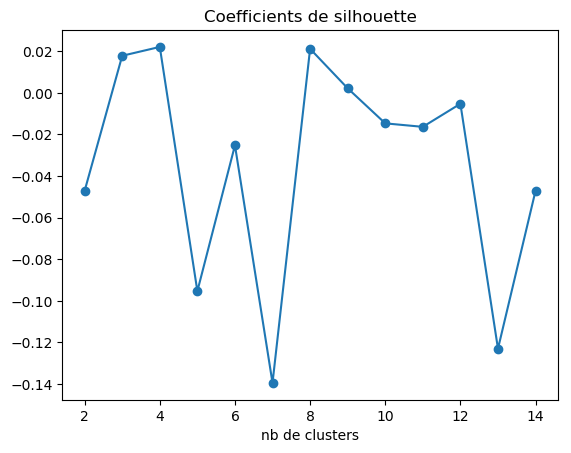

In [26]:
sil = []
nclust = range(2, 15)
for nu in nclust:
    cls = cluster.KMeans(n_clusters=nu, n_init=1, init='random')
    cls.fit(X_norm)
    si = metrics.silhouette_score(X_norm, cls.labels_)
    sil.append(si)
    
plt.plot(nclust, sil, marker='o')
plt.xlabel("nb de clusters")
plt.title("Coefficients de silhouette")

Text(0.5,1,'Coefficients de silhouette')

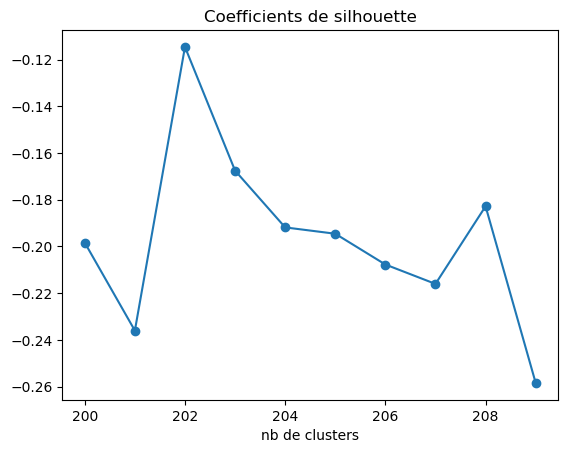

In [27]:
sil = []
nclust = range(200, 210)
for nu in nclust:
    cls = cluster.KMeans(n_clusters=nu, n_init=1, init='random')
    cls.fit(X_norm)
    si = metrics.silhouette_score(X_norm, cls.labels_)
    sil.append(si)
    
plt.plot(nclust, sil, marker='o')
plt.xlabel("nb de clusters")
plt.title("Coefficients de silhouette")

## PCA

In [32]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_norm)
print(pca.explained_variance_ratio_.cumsum())
X_trans = pca.transform(X_norm)

[ 0.00135842  0.00239996]


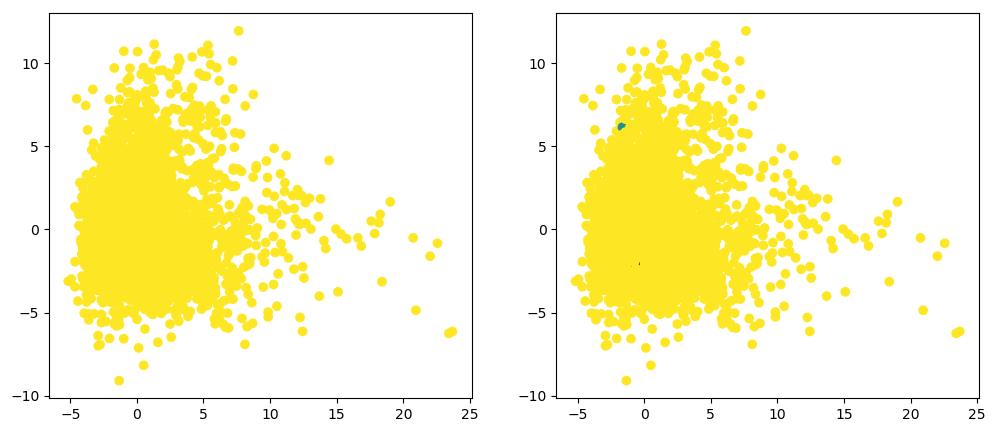

In [33]:
fig = plt.figure(figsize=(12, 5))

cls = cluster.KMeans(n_clusters=2)
cls.fit(X_norm)
ax = fig.add_subplot(121)
ax.scatter(X_trans[:, 0], X_trans[:, 1], c=cls.labels_)

cls3 = cluster.KMeans(n_clusters=3)
cls3.fit(X_norm)
ax = fig.add_subplot(122)
ax.scatter(X_trans[:, 0], X_trans[:, 1], c=cls3.labels_)